<a href="https://colab.research.google.com/github/SJinLee/PPG/blob/main/05.yurim_data0418.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 데이터만 준비된 상태
* HRV analysis 는 다음 사이트에서 계산법을 찾을 수 있음

https://github.com/Aura-healthcare/hrv-analysis

In [2]:
from scipy import io
mat_file = io.loadmat('yurim0418_8min.mat')

In [3]:
mat_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Apr 18 10:21:18 2024',
 '__version__': '1.0',
 '__globals__': [],
 'data': array([[482, 484, 486, ..., 493, 494, 494]], dtype=uint16)}

In [4]:
data = mat_file['data']

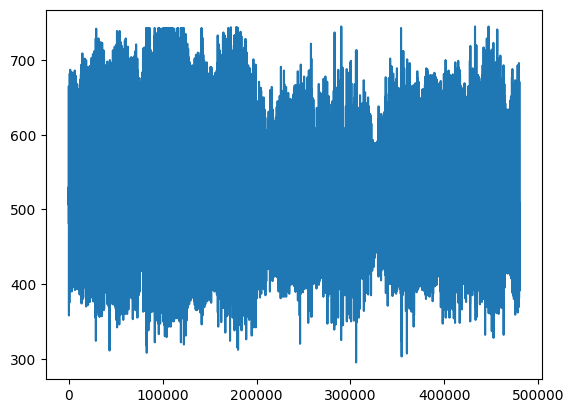

In [7]:
import matplotlib.pyplot as plt
plt.plot(data[0])

In [9]:
import pandas as pd

In [10]:
def get_lowpass(ppg):
    ppg2 = ppg.copy()
    d = 0.92
    a = d
    b = 1-d
    xi = ppg2['Red_Signal'].values[1:].astype(float).copy()
    v = ppg2['Red_Signal'].values.astype(float).copy()
    y = v[0]
    i = 1
    for x in xi:
        y += b*(x-y)
        v[i] = y
        i += 1
    ppg2['Red_Signal2'] = v
    ppg2['Time'] = pd.to_datetime(ppg2['Time'])
    return ppg2

In [19]:
import numpy as np
data2 = pd.DataFrame({'Red_Signal':data[0]})
data2['Time'] = pd.to_datetime('2024-04-11 00:00:00')+pd.Timedelta(milliseconds=1000/790)*data2.index
data3 = get_lowpass(data2)
diff=data3['Red_Signal2'].diff()
data3['peak'] = np.concatenate([[False],(diff.iloc[1:-1].values>0) & (diff.iloc[2:].values<0),[False]])
data3['peak2'] = data3['peak'] & (data3['Red_Signal']>600)

In [20]:
data3

,Red_Signal,Time,Red_Signal2,peak,peak2
0,482,2024-04-11 00:00:00.000000000,482.000000,False,False
1,484,2024-04-11 00:00:00.001265822,482.160000,False,False
2,486,2024-04-11 00:00:00.002531644,482.467200,False,False
3,491,2024-04-11 00:00:00.003797466,483.149824,False,False
4,492,2024-04-11 00:00:00.005063288,483.857838,False,False
...,...,...,...,...,...
479995,491,2024-04-11 00:10:07.588230890,477.586224,False,False
479996,494,2024-04-11 00:10:07.589496712,478.899326,False,False
479997,493,2024-04-11 00:10:07.590762534,480.027380,False,False
479998,494,2024-04-11 00:10:07.592028356,481.145190,False,False


In [21]:
import matplotlib.pyplot as plt
def draw_ppg(ppg2,start,period):
    t = ppg2['Time'][start:start+period]
    x = ppg2['Red_Signal'][start:start+period]
    y = ppg2['Red_Signal2'][start:start+period]
    plt.plot(t,x,label='input')
    plt.plot(t,y,label='output')
    if 'peak2' in ppg2:
        peak = ppg2['peak2'][start:start+period]
        plt.plot(t.loc[peak],y.loc[peak],'og')
    plt.legend()

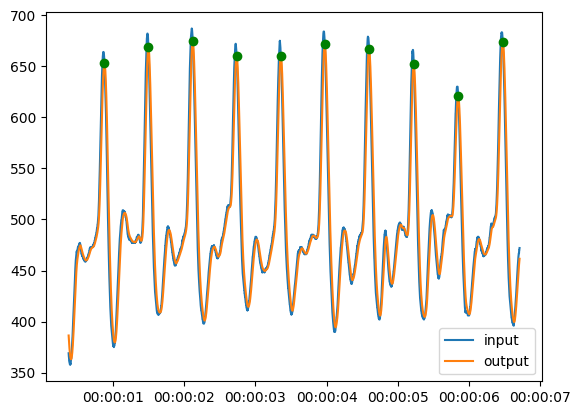

In [22]:
draw_ppg(data3,300,5000)

* RRInterval

In [38]:
rrinterval = data3.loc[data3['peak2']]['Time'].diff() / pd.to_timedelta(1, unit='S')
rrinterval = rrinterval.values[1:]
rrinterval.shape

(915,)

In [40]:
step = 20
for i in range(0,len(rrinterval),step):
    print(i,rrinterval[i:i+step].mean())

0 0.6215818931
20 0.6365185927000001
40 0.6174679716
60 0.7146831012
80 0.5943034289999999
100 0.5924679870999999
120 0.5844300174000001
140 0.5748730612999999
160 0.6230375884
180 0.6447464356999999
200 0.5950629221999999
220 0.65189833
240 0.6184806292
260 0.6218350575000001
280 0.6649995876999999
300 0.6421515006
320 0.5939236824
340 0.5924046960000001
360 0.5876578634999999
380 0.5712021775
400 0.6415818807
420 0.8515817505000001
440 0.6857590685
460 0.6024679809
480 0.7839235646
500 0.5972148196
520 0.8402526435999998
540 0.8102526621999999
560 0.8803159099
580 0.8060121585
600 1.2977207144
620 0.6556325049
640 0.6187337935999999
660 0.7527210523
680 0.5711388864
700 0.6089869642
720 0.618986958
740 0.6511388368000001
760 0.5602528172
780 0.5767085031999999
800 0.7027210833
820 0.6121515192
840 0.5946831756
860 0.6230375883999999
880 0.6296198628
900 0.5843878233333334


In [37]:
tm = rrinterval.cumsum() - rrinterval[0]

* use interpolate1d to do sampling